# PROJECT : CREDIT CARD USER SEGMENTATION USING DIFFERENT CLUSTERING TECHNIQUES.

# PART 2 : CLUSTERING MODEL BUILDING.

# NOTE : The Data Processing and Exploratory Data Analysis (EDA) part of the project is performed in  "User Segmentation (EDA).ipynb" file.

# Importing the modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report,confusion_matrix,accuracy_score
from collections import Counter
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
import scipy.cluster.hierarchy as shc
from sklearn.ensemble import RandomForestClassifier
import pickle

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
df = pd.read_csv('After_EDA.csv')
df.head()

,Unnamed: 0,Customer_ID,Card_type,City,Gender,Credit_limit,Balance,Payments,Purchases,Oneoff_purchases,Installment_purchases,Cash_advance,Purchase_frequency,Oneoff_purchase_frequency,Purchase_installment_frequency
0,0,C10001,Silver,Pune,Female,1000.0,40.900749,201.802084,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333
1,1,C10002,Gold,Kolkata,Male,7000.0,3202.467416,4103.032597,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0.000000
2,2,C10003,Gold,Kolkata,Male,7500.0,2495.148862,622.066742,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000
3,3,C10004,Gold,Kolkata,Male,7500.0,1666.670542,0.000000,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,0.000000
4,4,C10005,Silver,Pune,Female,1200.0,817.714335,678.334763,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000


# Data Preparation

In [3]:
# Dropping the non required features

df.drop(['Unnamed: 0','Customer_ID'],axis=1,inplace=True)

In [4]:
# Creating a copy of the dataset for model building purpose

df1 = df.copy()

In [5]:
# Ordinal Encoding of categorical features based on the 'Cred_limit' variable

for i in df1.columns:
    if df1[i].dtype == 'object':
        categories = df1.groupby(i)['Credit_limit'].sum().sort_values(ascending=False).index.to_list()
        order = [x for x in range(len(categories),0,-1)]
        df1.replace(categories,order,inplace=True) 

### Here we've used a unique ordinal encoding method to encode the categorical features based on the 'Credit_limit' variable, using the insights generated from Exploratory Data Analysis. For example, a category having higher value of Credit limit will be given a higher order or integer in the encoding, whereas a category having lower value of Credit limit will be assigned a lower number.

In [6]:
# Encoded dataset
df1.head(5)

,Card_type,City,Gender,Credit_limit,Balance,Payments,Purchases,Oneoff_purchases,Installment_purchases,Cash_advance,Purchase_frequency,Oneoff_purchase_frequency,Purchase_installment_frequency
0,3,3,1,1000.0,40.900749,201.802084,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333
1,4,6,2,7000.0,3202.467416,4103.032597,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0.000000
2,4,6,2,7500.0,2495.148862,622.066742,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000
3,4,6,2,7500.0,1666.670542,0.000000,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,0.000000
4,3,3,1,1200.0,817.714335,678.334763,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000


In [7]:
# Scaling the features using Standardscaler
sc = StandardScaler()
df1 = pd.DataFrame(sc.fit_transform(df1),columns=df1.columns)

# PRINCIPAL COMPONENT ANALYSIS TO IDENTIFY THE TWO MAIN FEATURES FOR CLUSTERING

In [8]:
pca = PCA(n_components=2)
pca = pd.DataFrame(pca.fit_transform(df1),columns = ['PC1','PC2'])
pca.head(2)

,PC1,PC2
0,-2.339415,-1.381974
1,-0.734377,4.014051


In [9]:
# Creating an array of principal components

pca_array = pca.to_numpy()
pca_array

array([[-2.33941453, -1.38197385],
       [-0.73437661,  4.01405111],
       [ 1.58799437,  1.33324258],
       ...,
       [-1.23813887, -2.34532237],
       [-2.76108928, -1.22381644],
       [ 0.1872673 , -1.37810473]])

In [12]:
# Total Explained variance by the two principal components

pca_variance = PCA(n_components=2).fit(df1)
print('Total variance explained by the two Principal components is :',round(pca_variance.explained_variance_.sum()*10,2), '%')

Total variance explained by the two Principal components is : 69.26 %


# K-Means Clustering Model

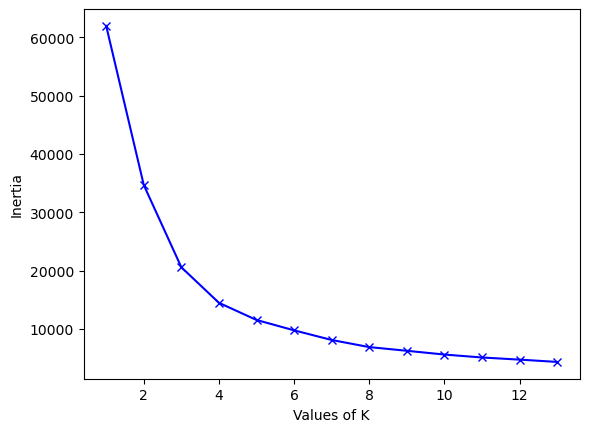

In [13]:
# Identifying optimum value of clusters for K-Means Model using the Elbow method

inertia = []
range_ = range(1,14)
for i in range_:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(pd.DataFrame(pca))
    inertia.append(kmean.inertia_)
plt.plot(range_,inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.show()

### Elbow method is a technique that is used to determine the ideal numbers of clusters to be created. For every value of k, it calculates the within-cluster sum of square (WCSS) distance between centroids of the clusters and each data point. To determine the optimal number of cluster, we have to select the value of k at the elbow after which the distortion/inertia starts decreasing.  Here we can observe that the optimal value of cluster came out to be in a range of 4 to 8. So we will validate the silhouette score for each cluster in range of 4 to 8.

In [14]:
import matplotlib.cm as cm

For n_clusters = 4 The average silhouette score is : 0.4208377620158979


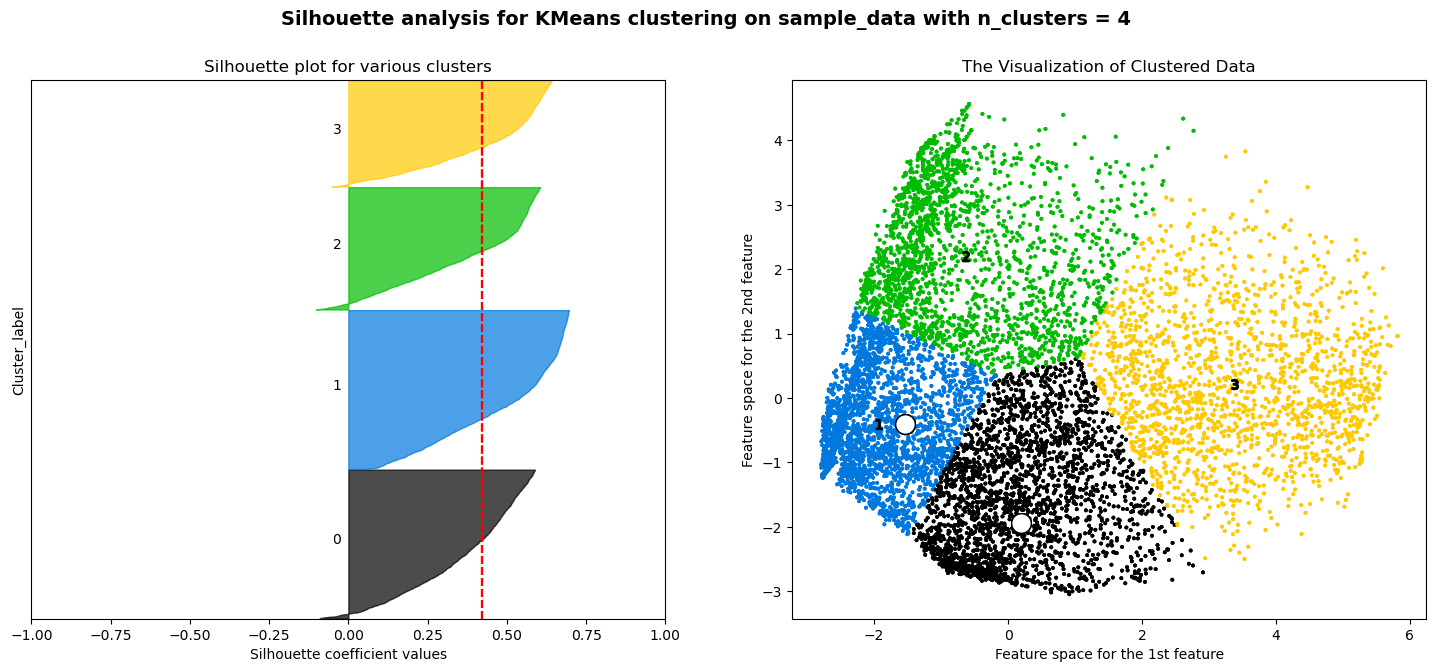

For n_clusters = 5 The average silhouette score is : 0.42024236469810594


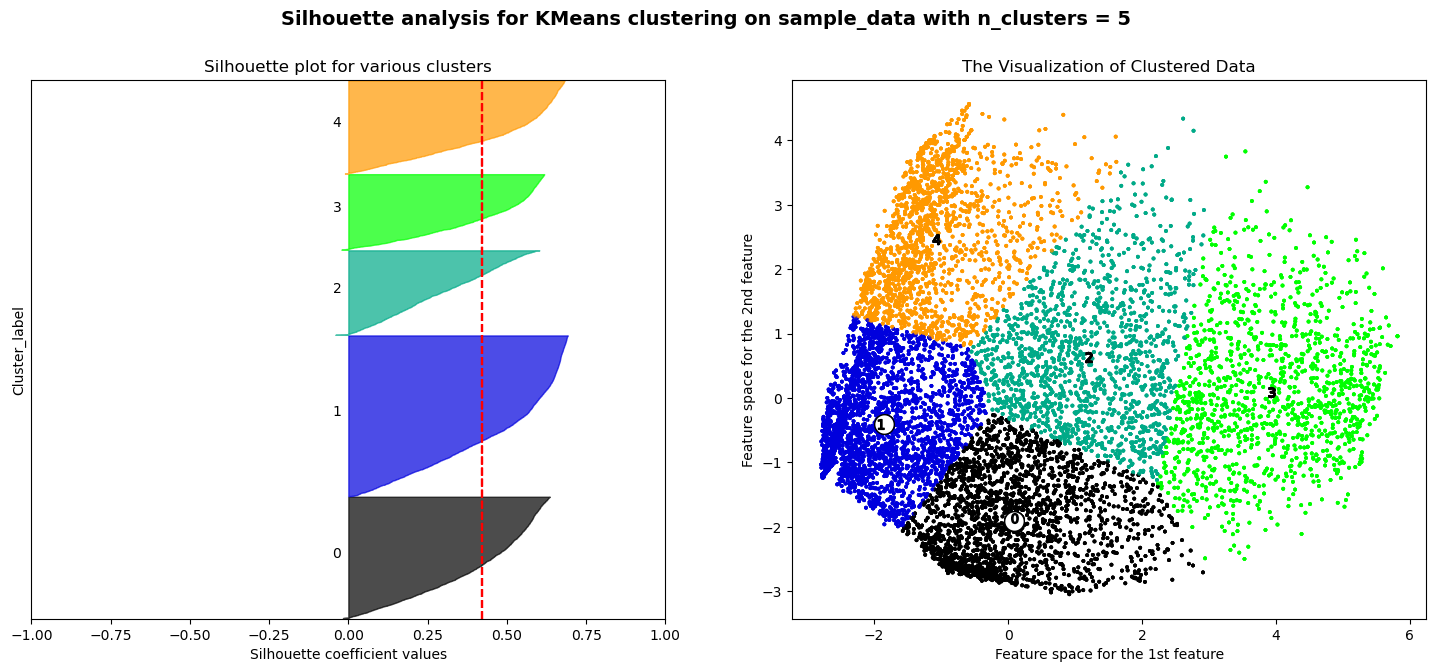

For n_clusters = 6 The average silhouette score is : 0.4084218024478234


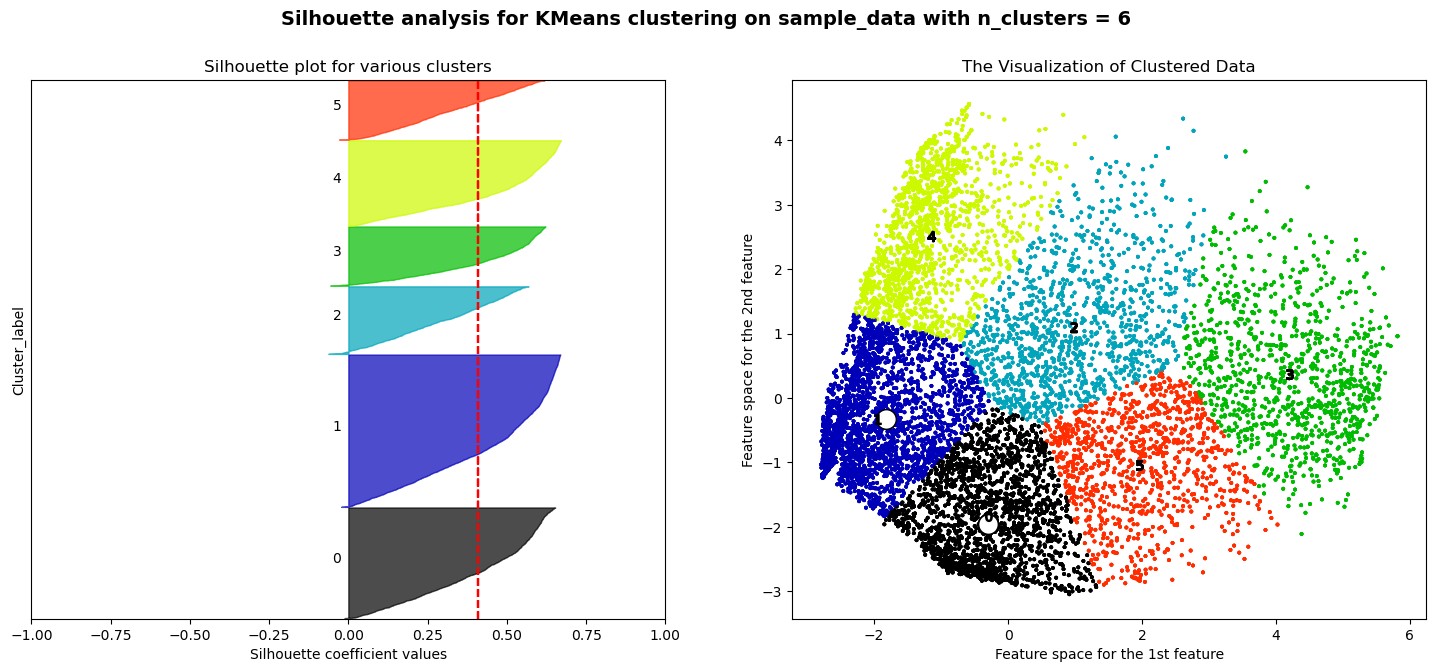

For n_clusters = 7 The average silhouette score is : 0.42148842886239773


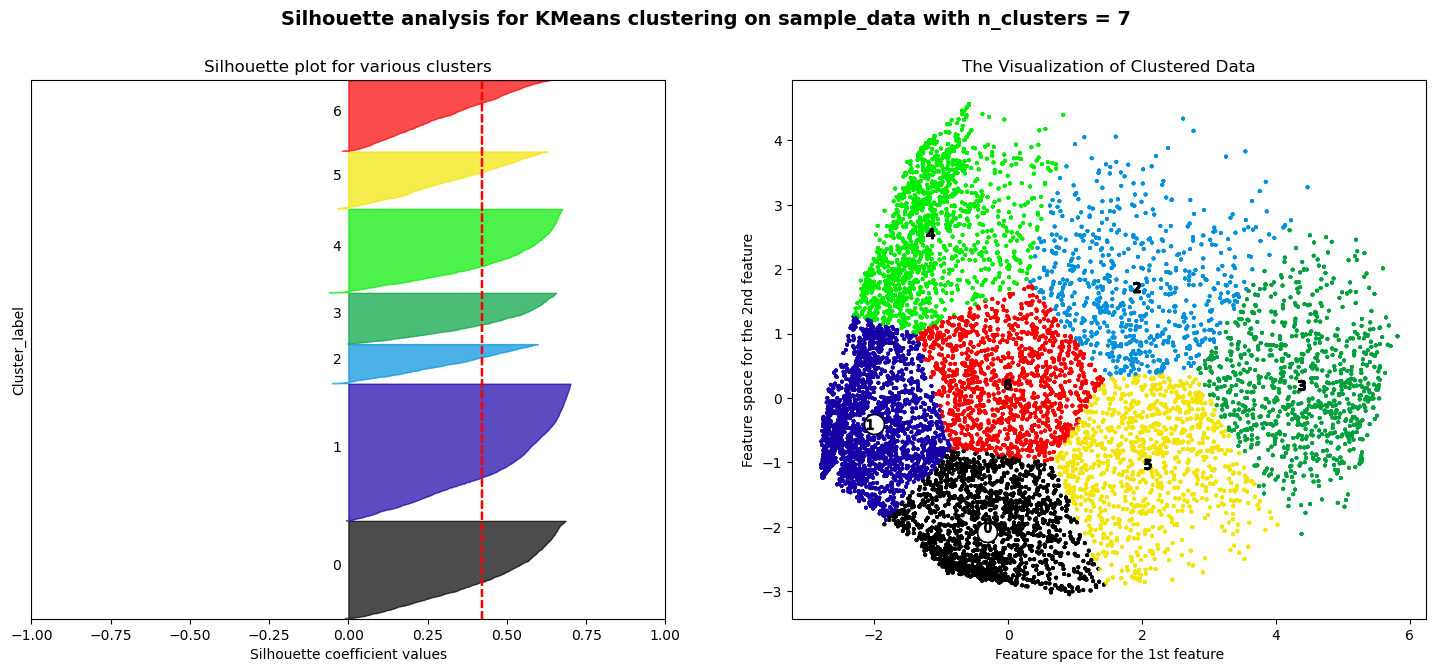

For n_clusters = 8 The average silhouette score is : 0.41753373035300045


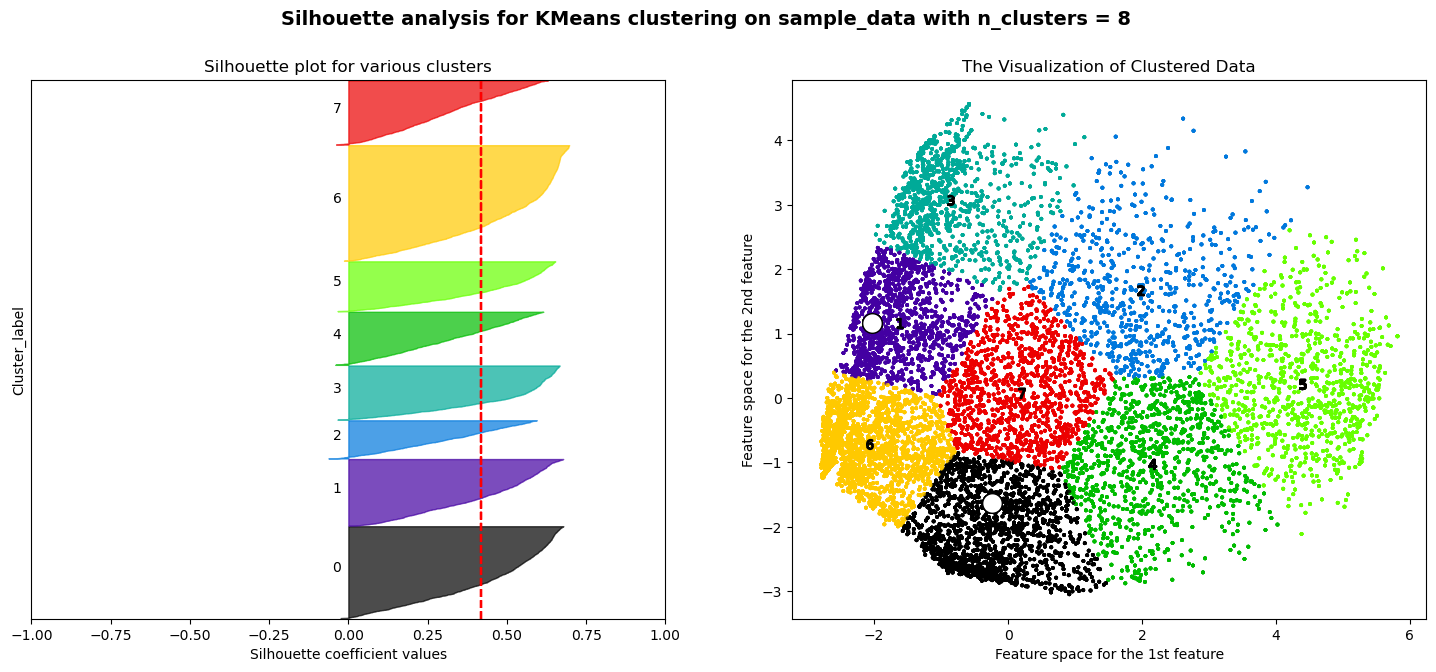

In [15]:
# Checking Silhouette score for each cluster
cluster_range = [4,5,6,7,8]
for n_clusters in cluster_range:
    fig, (ax1, ax2) = plt.subplots(1,2)  # Creating a subplot with 1 row and 2 columns
    fig.set_size_inches(18,7)
    
    
    ax1.set_xlim([-1,1])  # The Silhouette coefficient can range from -1,1
    
    ax1.set_ylim([0, len(pca_array) + (n_clusters + 1) * 10])  # Inserting blank space between silhouette plots 
    
    clusters = KMeans(n_clusters = n_clusters,random_state = 10) # Initialising the clusters with n_clusters value
    cluster_label = clusters.fit_predict(pca_array)
    
    silhouette_avg = silhouette_score(pca_array, cluster_label) # Calculating Silhouette score
    print(
    'For n_clusters =', n_clusters, 'The average silhouette score is :', silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(pca_array,cluster_label)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_label == i]
        ith_cluster_silhouette_values.sort() # Aggregate the Silhouette score and sorting them
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor = color, edgecolor = color,
                         alpha = 0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the Silhouette plots with their cluster numbers
        
        y_lower = y_upper + 10 # Compute the new y_lower for next plot
        
        ax1.set_title('Silhouette plot for various clusters')
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster_label')
        
        ax1.axvline(x = silhouette_avg, color = 'red', linestyle = '--') # Vertical line for average silhouette score
        ax1.set_yticks([])
        
        # 2nd plot showing the actual clusters formed
        color = cm.nipy_spectral(cluster_label.astype(float) / n_clusters)
        ax2.scatter(pca_array[:,0], pca_array[:,1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = color,
                    edgecolor = 'k')
        
        # Labeling the clusters
        centers = clusters.cluster_centers_
        # Draw white clusters at cluster centers
        ax2.scatter(centers[0], centers[1], marker = 'o', c = 'white', alpha = 1, s = 200, edgecolor = 'k')
        
        for i, c in enumerate(centers):
            ax2.scatter(c[0],c[1],marker = '$%d$' % i, alpha = 1, s = 50, edgecolor = 'k')
            
        ax2.set_title('The Visualization of Clustered Data')
        ax2.set_xlabel('Feature space for the 1st feature')
        ax2.set_ylabel('Feature space for the 2nd feature')
        
        plt.suptitle(('Silhouette analysis for KMeans clustering on sample_data with n_clusters = %d' % n_clusters),
                    fontsize=14, fontweight='bold')
    plt.show()

### Here we can observe that though the silhouette coefficient values for n_clusters 4, 5, and 7 are approximately same (0.42) ,  but more values in n_clusters = 4 and 7 are showing negative coefficient as compared to the values in n_cluster = 5. Hence, the ideal number of clusters should be 5  (if the silhouette coefficient value is close to 1, it means the data points are clustered very well to the respective clusters and if the value is 0 or in negative, it indicates inefficient cluster formation.

## Cluster Formation based on K-Means model.

In [16]:
k_model = KMeans(5)   # Ideal number of clusters is 5 (Based on KMeans model)
k_model.fit_predict(pca)
k_model_df = pd.concat([pca,pd.DataFrame({'Cluster': k_model.labels_})],axis=1)
k_model_df.head(2)

,PC1,PC2,Cluster
0,-2.339415,-1.381974,3
1,-0.734377,4.014051,1


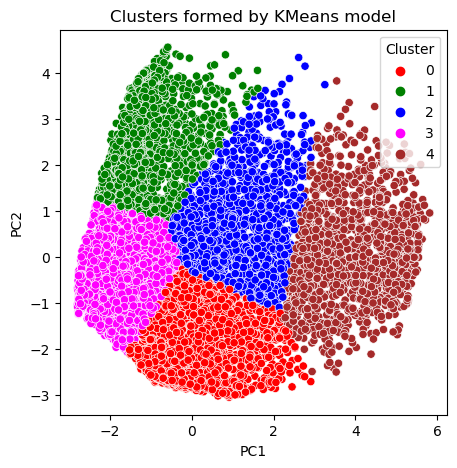

In [17]:
# Visualizing the clusters using scatterplot

plt.figure(figsize=(5,5))
ax = sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Cluster', data = k_model_df, palette = ['red','green','blue','magenta',
                                                                                           'brown'])
plt.title('Clusters formed by KMeans model')
plt.show()

# DENSITY BASED SPATIAL CLUSTERING OF APPLICATIONS WITH NOISE (DBSCAN Clustering)

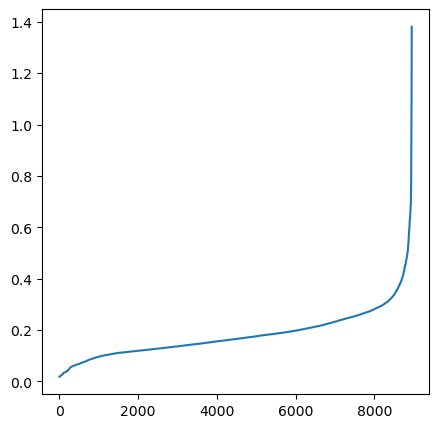

In [19]:
# Finding the optimum value of 'epsilon' parameter based on K-distance graph

nn = NearestNeighbors(n_neighbors=25).fit(pca)
distances, indices = nn.kneighbors(pca)
distances = np.sort(distances,axis=0)
distances = distances[:,-1]

plt.figure(figsize=(5,5))
plt.plot(distances)
plt.show()

## Observation
* The optimum value of epsilon is at the point of maximum curvature in the K-Distance Graph, which is 0.4 in this case.

In [20]:
# Calculating the optimum clusters formed by DBSCAN method and its silhouette score based on the epsilon value 0.4

labels = DBSCAN(min_samples = 10, eps = 0.4).fit(pca).labels_
clusters = len(Counter(labels))
print('The optimum clusters for DBSCAN Clustering model is', clusters)
print('Outliers detected by the model ', Counter(labels)[-1])
print('Silhouette score for the cluster', silhouette_score(pca, labels))

The optimum clusters for DBSCAN Clustering model is 2
Outliers detected by the model  9
Silhouette score for the cluster 0.343566465550745


### OBSERVATION -- THE IDEAL NUMBER OF CLUSTERS FORMED THE BY DBSCAN METHOD ARE 2, WITH THE SILHOUETTE SCORE  0.34 (approx) .

In [21]:
# Creating Clusters based on DBSCAN model

db_model = DBSCAN(min_samples = 10, eps = 0.4)
db_model.fit_predict(pca)
db_model_df = pd.concat([pca,pd.DataFrame({'Cluster': db_model.labels_})],axis=1)

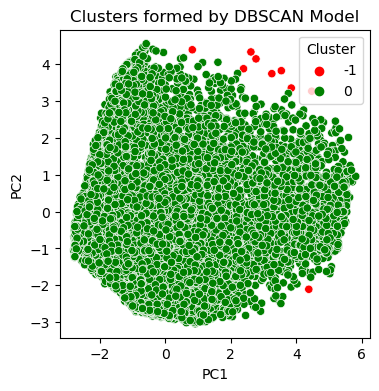

In [22]:
# Visualizing the DBSCAN clusters using scatterplot

plt.figure(figsize=(4,4))
ax = sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Cluster', data = db_model_df, palette = ['red','green'])
plt.title('Clusters formed by DBSCAN Model')
plt.show()

### IT CAN BE CLEARLY OBSERVED THAT THE DBSCAN MODEL IS NOT ABLE TO BUILD PROPER CLUSTERS FOR THE GIVEN FEATURES.

# AGGLOMERATIVE HIERARCHIAL CLUSTERING

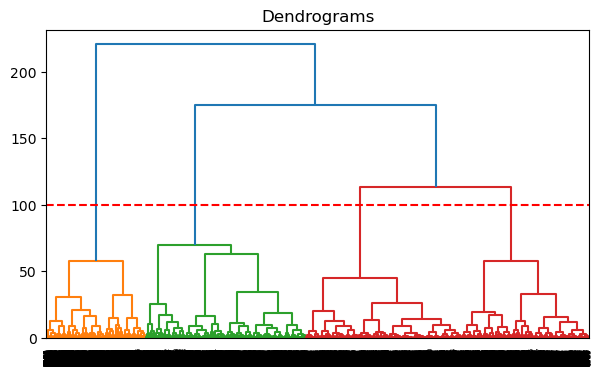

In [24]:
# Creating a Dendrogram to find the optimum number of clusters

plt.figure(figsize=(7,4))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(pca, method = 'ward'))
plt.axhline(y=100, color ='r', linestyle = '--')

## OBSERVATION 

 * A dendrogram is a tree like diagram that records the sequence of merges and splits. More the distance of the vertical lines in the dendrogram, more the distance between those clusters.
 
 * We have set the threshold distance = 100, so that the horizontal red line cuts the tallest vertical line.
 * The number of clusters will be the number of vertical lines intersected by the threshold line. Based on that, the optimum number of clusters came out to be 4.

In [27]:
# Creating Clusters based on Agglomerative Clustering Model

hierarchial_model = AgglomerativeClustering(n_clusters=4)  # The optimum number of clusters are 4
hierarchial_model.fit_predict(pca)
hierarchial_model_df = pd.concat([pca,pd.DataFrame({'Cluster': hierarchial_model.labels_})],axis=1)

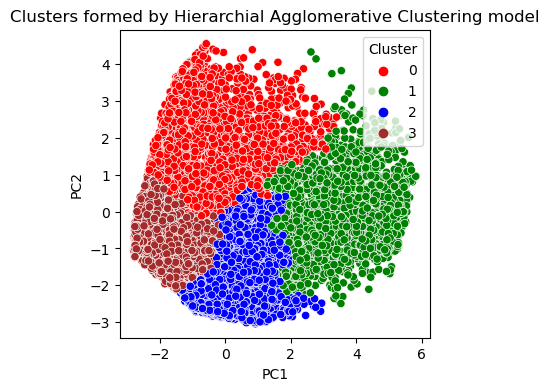

In [28]:
# Visualizing the Agglomerative cluster through scatterplot

plt.figure(figsize=(4,4))
ax = sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Cluster', data = hierarchial_model_df, palette = ['red','green','blue',
                                                                                                   'brown'])
plt.title('Clusters formed by Hierarchial Agglomerative Clustering model')
plt.show()

In [29]:
# Silhouette score for Agglomerative hierarchial clustering

score = silhouette_score(pca,hierarchial_model.fit_predict(pca))
print('Silhouette score for Agglomertive Clustering model is: ', score)

Silhouette score for Agglomertive Clustering model is:  0.3878987189414163


# IDENTIFYING THE BEST PERFORMING MODEL

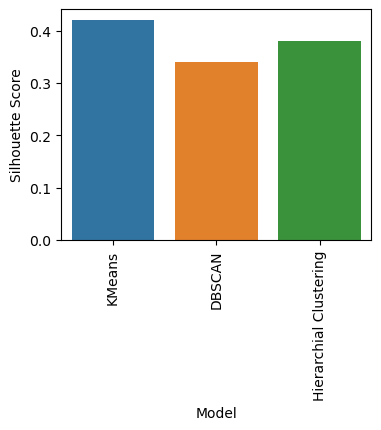

In [30]:
all_model_df = pd.DataFrame({
    'Model':['KMeans','DBSCAN','Hierarchial Clustering'],
    'Recommended Clusters':[5,2,4],
    'Silhouette Score':[0.42,0.34,0.38]
})

plt.figure(figsize=(4,3))
sns.barplot(x='Model', y ='Silhouette Score', data = all_model_df)
plt.xticks(rotation = 90)
plt.show()


### Based on the Silhouette score and visualization of the clusters, it can be observed that the KMeans clustering model is the best performing model, creating the most efficient clusters.

# Assigning the  Clusters Formed By Kmeans Model To Each User.

In [31]:
cluster = k_model_df[['Cluster']]
df = pd.concat([df,cluster], axis = 1)
df[['Cluster']].head(2)

,Cluster
0,3
1,1


In [34]:
# Saving the data containing Clusters

df.to_csv('Clustered_data')

# TRAINING A RANDOM FOREST CLASSIFICATION MODEL TO PREDICT THE CLUSTERS BASED ON INPUT FEATURES.

In [35]:
# Ordinal Encoding of categorical features based on the target variable, that, is, Cluster

for i in df.columns:
    if df[i].dtype == 'object':
        categories = df.groupby(i)['Credit_limit'].count().sort_values(ascending=False).index.to_list()
        order = [x for x in range(len(categories),0,-1)]
        df.replace(categories,order,inplace=True) 

## Here, the categories having a higher count of clusters will be given a higher order, and the categories having lower count of cluster will be assigned a lower order.

In [37]:
# Splitting the data into training and testing sets

x = df.drop(['Cluster'],axis=1)
y = df[['Cluster']]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=20)

In [38]:
# Scaling the data using Standardscaler

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [41]:
# Training the Random Forest Classifier

model = RandomForestClassifier(n_estimators = 35, criterion = 'entropy')
model.fit(x_train,y_train)
y_pred = model.predict(x_test)


# Evaluating the model using confusion matrix and accuracy score
print(confusion_matrix(y_test,y_pred),'\n')
print(classification_report(y_test,y_pred),'\n')
print(round(accuracy_score(y_test,y_pred)*100,2),'\n')

[[411   0   5   5   1]
 [  0 292  10   8   0]
 [  9   5 260   5  10]
 [  7  12   3 504   0]
 [  1   0   8   0 234]] 

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       422
           1       0.94      0.94      0.94       310
           2       0.91      0.90      0.90       289
           3       0.97      0.96      0.96       526
           4       0.96      0.96      0.96       243

    accuracy                           0.95      1790
   macro avg       0.95      0.95      0.95      1790
weighted avg       0.95      0.95      0.95      1790
 

95.03 



## The accuracy of the RandomForest Classifier came out to be 95.03%

# SAVING THE MODEL FOR DEPLOYMENT

In [42]:
pickle.dump(model,open('model.pkl','wb'))